In [23]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
import seaborn as sns

import statsmodels.api as sm
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the data

In [4]:
file = "../Data/result_full_factorial_pgm.csv"

In [5]:
data = pd.read_csv(file)

In [7]:
data.shape

(151956, 18)

In [8]:
data.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
enzyme_complex_concentration    float64
enzyme_concentration            float64
k1_bwd_effective                float64
k1_bwd_relative                 float64
k1_fwd_effective                float64
k1_fwd_relative                 float64
k2_bwd_effective                float64
k2_bwd_relative                 float64
k2_fwd_effective                float64
k2_fwd_relative                 float64
mu_mass                         float64
product_concentration           float64
realization                     float64
sigma_mass                      float64
substrate_concentration         float64
volume_fraction                 float64
dtype: object

In [9]:
data.drop('Unnamed: 0.1', axis=1, inplace=True)
data.drop("Unnamed: 0",axis = 1, inplace = True)
data.head()

,enzyme_complex_concentration,enzyme_concentration,k1_bwd_effective,k1_bwd_relative,k1_fwd_effective,k1_fwd_relative,k2_bwd_effective,k2_bwd_relative,k2_fwd_effective,k2_fwd_relative,mu_mass,product_concentration,realization,sigma_mass,substrate_concentration,volume_fraction
0,0.000058,0.000006,4.503135,0.450314,262554.802451,1.723016,7.139138e+05,2.164051,9.907347,0.450334,12.1,0.000098,2.0,0.000,0.000049,0.2
1,0.000006,0.000058,4.491493,0.449149,285144.598410,1.871261,6.227429e+05,1.887689,9.879449,0.449066,12.1,0.000147,3.0,0.000,0.000245,0.2
2,0.000019,0.000045,7.636543,0.763654,262351.891789,1.721684,6.597299e+05,1.999806,16.799770,0.763626,31.9,0.000016,5.0,0.825,0.000024,0.2
3,0.000013,0.000051,0.634308,0.063431,484409.307429,3.178936,1.063666e+06,3.224238,1.395557,0.063434,12.1,0.000196,8.0,0.000,0.000012,0.4
4,0.000006,0.000058,4.416002,0.441600,281281.994713,1.845913,5.871605e+05,1.779830,9.719614,0.441801,12.1,0.000049,4.0,0.000,0.000147,0.2


In [10]:
data.describe()

,enzyme_complex_concentration,enzyme_concentration,k1_bwd_effective,k1_bwd_relative,k1_fwd_effective,k1_fwd_relative,k2_bwd_effective,k2_bwd_relative,k2_fwd_effective,k2_fwd_relative,mu_mass,product_concentration,realization,sigma_mass,substrate_concentration,volume_fraction
count,151956.000000,151956.000000,151956.000000,151956.000000,1.519560e+05,151956.000000,1.519560e+05,151956.000000,151956.000000,151956.000000,151956.000000,151956.000000,151956.000000,151956.000000,151956.000000,151956.000000
mean,0.000032,0.000032,4.485190,0.448519,3.547550e+05,2.328080,7.684298e+05,2.329303,9.867422,0.448519,25.702332,0.000089,4.499868,0.236865,0.000088,0.287063
std,0.000017,0.000017,3.072361,0.307236,1.381388e+05,0.906536,3.001688e+05,0.909887,6.759198,0.307236,9.444865,0.000083,2.872318,0.373242,0.000083,0.151795
min,0.000006,0.000006,0.214156,0.021416,1.043541e+04,0.068482,6.777663e+04,0.205448,0.470188,0.021372,12.100000,0.000010,0.000000,0.000000,0.000010,0.000000
25%,0.000019,0.000019,1.449146,0.144915,2.328432e+05,1.528034,5.021104e+05,1.522022,3.187629,0.144892,21.100000,0.000016,2.000000,0.000000,0.000016,0.200000
50%,0.000032,0.000032,4.424981,0.442498,3.309195e+05,2.171659,7.152682e+05,2.168157,9.735084,0.442504,31.900000,0.000049,4.000000,0.000000,0.000049,0.300000
75%,0.000045,0.000045,7.243627,0.724363,4.817919e+05,3.161759,1.044737e+06,3.166859,15.936100,0.724368,31.900000,0.000147,7.000000,0.825000,0.000147,0.400000
max,0.000058,0.000058,9.947790,0.994779,1.043541e+06,6.848235,2.159815e+06,6.546940,21.885279,0.994785,36.800000,0.000245,9.000000,0.825000,0.000245,0.500000


# From the paper, theory

Linear regression to estimate $\beta$ and $\alpha_j$ in the following model:

\begin{equation*}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \alpha_{E,j}log(\frac{[E]}{[E]_0}) + \alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \alpha_{P,j}log(\frac{[P]}{[P]_0})  + \alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation*}

where $j\in [1_{bwd}, 1_{fwd}, 2_{bwd}, 2_{fwd}]$,

$k$ is the effective rate constant, and $k_0$ is the relative rate constant

The given concentration is (??) $[X]/[X]_0$

#### knowing that be modify our data set in order to have the $log(\frac{k_j}{k_{j,0}})$ as a feature we will try to predict

In [26]:
# create transformed dataframe
data_trans = data.copy()

#log of the ratio
data_trans['log_k1_bwd'] = np.log(data_trans['k1_bwd_effective']/data_trans['k1_bwd_relative'])
data_trans['log_k1_fwd'] = np.log(data_trans['k1_fwd_effective']/data_trans['k1_fwd_relative'])
data_trans['log_k2_bwd'] = np.log(data_trans['k2_bwd_effective']/data_trans['k2_bwd_relative'])
data_trans['log_k2_fwd'] = np.log(data_trans['k2_fwd_effective']/data_trans['k2_fwd_relative'])


#computation of initial concentration
E_tot = 64

P0 = 49
S0 = 49

E0 = E_tot
ES0 = S0- data_trans.substrate_concentration



#computation of the log of the ration of the concentration
data_trans['E'] = np.log(data_trans['enzyme_concentration']/E0)
data_trans['ES'] = np.log(data_trans['enzyme_complex_concentration']/ES0)
data_trans['P'] = np.log(data_trans['product_concentration']/P0)
data_trans['S'] = np.log(data_trans['substrate_concentration']/S0)



#dropping the covariates we don't need anymore
data_trans.drop(['k1_bwd_effective','k1_bwd_relative', 'k1_fwd_effective',
                'k1_fwd_relative', 'k2_bwd_effective', 'k2_bwd_relative',
                'k2_fwd_effective', 'k2_fwd_relative', 'enzyme_concentration',
                'enzyme_complex_concentration', 'product_concentration',
                'substrate_concentration'], axis=1, inplace=True)
data_trans.head()

,mu_mass,realization,sigma_mass,volume_fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd,E,ES,P,S
0,12.1,2.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-16.118096,-13.653807,-13.122363,-13.815511
1,12.1,3.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-13.920871,-15.851028,-12.716898,-12.206073
2,31.9,5.0,0.825,0.2,2.302585,11.934139,12.706535,3.091042,-14.172186,-14.752420,-14.914125,-14.508658
3,12.1,8.0,0.000,0.4,2.302585,11.934139,12.706535,3.091042,-14.038654,-15.157885,-12.429216,-15.201805
4,12.1,4.0,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-13.920871,-15.851030,-13.815511,-12.716898


### realization 

`realization` does not seem to be a relevant variable, since it only index the sample of an experiment, hence we remove it 



In [27]:
data_trans.drop('realization',axis = 1, inplace = True)

In [29]:
data_trans.head()

,mu_mass,sigma_mass,volume_fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd,E,ES,P,S
0,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-16.118096,-13.653807,-13.122363,-13.815511
1,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-13.920871,-15.851028,-12.716898,-12.206073
2,31.9,0.825,0.2,2.302585,11.934139,12.706535,3.091042,-14.172186,-14.752420,-14.914125,-14.508658
3,12.1,0.000,0.4,2.302585,11.934139,12.706535,3.091042,-14.038654,-15.157885,-12.429216,-15.201805
4,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-13.920871,-15.851030,-13.815511,-12.716898


basically the log ration of the concentration only depends on the volume fraction, the sigma mass and the mu mass: we don't need the covariate [E], [S], [ES], [P] and we can predict exactly the results

In [40]:
data_trans[(data_trans['volume_fraction']== 0.0) & (data_trans['sigma_mass'] == 0.825) & (data_trans['mu_mass'] == 31.9)].log_k1_bwd.unique()-2.30258509

array([2.99404590e-09, 2.99404634e-09, 2.99404546e-09])

change happens at $10^{-14}$

# Computation of the residuals   

### note

We have to do this for each "group" define by a combination of values of `sigma_mass`, `mu_mass` and `volume_occupation`

following the paper process we compute regression like the following one : 


`log_k_j` = $\beta + \alpha_1$ `E` + $r_E$

and then compute an estimate of the variance: 

$\sqrt{\frac{RSS}{n-2}}$  where RSS = $|| r_E||_2^2$

In [44]:
#create dataframe to do the regression
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [97]:
#do the regression and return the model fitted
def regression(X,y):
    reg = LinearRegression()
    reg.fit(X,y)
    
    y_hat = reg.predict(X)
    coeffs = reg.coef_
    residuals = (y-y_hat).values
    return coeffs,y_hat,residuals

In [78]:
mus = data.mu_mass.unique()
sigmas = data.sigma_mass.unique()
volumes = [0.1,0.2,0.3,0.4,0.5]

names = ["E","ES","P","S"]

In [53]:
def Regressors(data):
    '''
    return a vector containing the design matrix for the regression of the log efficient rate ratio against 
    E,ES,P,S in that order
    '''
    X_total = []
    for name in names:
        X_total.append(create_regressors(data,name))
    return X_total

In [58]:
#combination done into the paper
combinations = [[31.9,0.825],[12.1,0],[21.1,0],[36.8,0]]

we do the regression oonly for `log_k1_forward`

In [98]:
results = []

for volume in volumes:
    for comb in combinations:
        mu = comb[0]
        sigma =comb[1]
        #take data wth corresponding values in mu, sigma and volume fraction
        data_tested = data_trans[(data_trans['volume_fraction']== volume) & (data_trans['sigma_mass'] == sigma) 
                                         & (data_trans['mu_mass'] == mu)]
        
        
        #build regression matrices
        X_total = Regressors(data_tested)
        y = data_tested.log_k1_bwd
        
        #storage for the model
        #do the regression for each individual regressor (E,ES,P,S)
        for X in X_total:
            c,y_,r = regression(X,y)
            results.append([volume,mu,sigma,c,y_,r])


In [101]:
results =  pd.DataFrame(results)
results.columns = ["volume fraction","mu mass","sigma mass","coefficients","fitted values","residuals"]
results

,volume fraction,mu mass,sigma mass,coefficients,fitted values,residuals
0,0.1,31.9,0.825,"[0.0, -1.1826532493034007e-18]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.1,31.9,0.825,"[0.0, 6.92593546833943e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.1,31.9,0.825,"[0.0, -9.460135585190809e-20]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.1,31.9,0.825,"[0.0, 1.0681359774515426e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.1,12.1,0.000,"[0.0, 1.8207321915503253e-20]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,0.1,12.1,0.000,"[0.0, 1.7334797877025802e-18]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,0.1,12.1,0.000,"[0.0, 9.404748626980973e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,0.1,12.1,0.000,"[0.0, 6.981325400170859e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,0.1,21.1,0.000,"[0.0, 6.776908099732038e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,0.1,21.1,0.000,"[0.0, 1.647184023219901e-19]","[2.302585092994046, 2.302585092994046, 2.30258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Test the reproducibility

### for $log\left(\frac{k_{1,\text{forward,eff}}}{k_{1,\text{forward,relative}}}\right)$, using volume fraction  = $0.0$

In [17]:
# select data corresponding to our case
data_test = data_trans[data_trans['volume_fraction']==0.0]

#define the y for the regression
y = data_test["log_k1_fwd"]

#define the features we will regress on
x = data_test[['E', 'ES', 'P', 'S']].values
X = X = np.c_[np.ones(len(x)), x] #add intercept

In [18]:
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [19]:
data_test.size

80190

from the paper, we excpect to have the following result: 

$\beta = 7.31e-2$

$\alpha = [4.74e-3,1.07e-2,-,-]$ for the following features: S, E, ES, P

#### residuals computed from regression with all the features 

first we compute a regular linear regression in order to estimate the conitionnal variance of the residuals:

In [20]:
#fit linear model
reg = LinearRegression()
X_E = create_regressors(data_test,['E','ES','P','S'])
reg.fit(X_E,y)

#get the fitted values
y_hat = reg.predict(X_E)
residuals = (y-y_hat).values

#compute the residuals

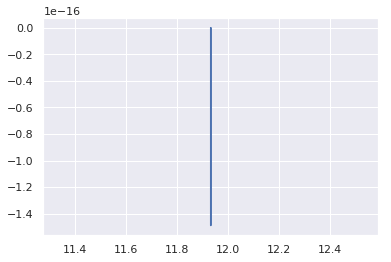

In [21]:
plt.plot(y_hat,residuals/y)
plt.show()

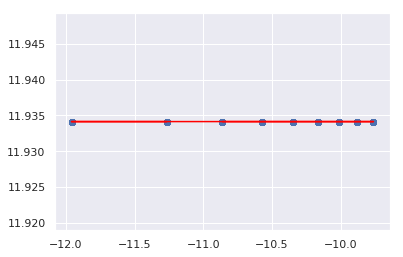

In [22]:
plt.scatter(y = y, x = data_test['E'].values)
plt.plot(data_test['E'].values, y_hat,color='red')
plt.show()

since s = RSS: 

In [23]:
weight_estimate = np.sqrt(np.var(residuals)/(X_E.size -2))

In [24]:
data_test_weighted = data_test.copy()
data_test_weighted['E'] =  data_trans['E']/weight_estimate
data_test_weighted['ES'] = data_trans['ES']/weight_estimate
data_test_weighted['P'] =  data_trans['P']/weight_estimate
data_test_weighted['S'] =  data_trans['S']/weight_estimate
data_test_weighted.describe()

,mu_mass,sigma_mass,volume_fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd,E,ES,P,S
count,7.290000e+03,7.290000e+03,7290.0,7.290000e+03,7.290000e+03,7290.000000,7.290000e+03,7.290000e+03,7.290000e+03,7.290000e+03,7.290000e+03
mean,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-6.850078e+18,-6.850078e+18,-6.451497e+18,-6.451497e+18
std,3.552957e-15,1.110299e-16,0.0,1.847847e-16,1.751323e-15,0.000000,3.908123e-16,4.408877e+17,4.408877e+17,7.631140e+17,7.631140e+17
min,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-7.774812e+18,-7.774812e+18,-7.497810e+18,-7.497810e+18
25%,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-7.060592e+18,-7.060592e+18,-7.165718e+18,-7.165718e+18
50%,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-6.728499e+18,-6.728499e+18,-6.451497e+18,-6.451497e+18
75%,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-6.509755e+18,-6.509755e+18,-5.737278e+18,-5.737278e+18
max,3.190000e+01,8.250000e-01,0.0,2.302585e+00,1.193414e+01,12.706535,3.091042e+00,-6.346373e+18,-6.346373e+18,-5.405184e+18,-5.405184e+18


In [39]:
data_test_weighted

,mu_mass,sigma_mass,volume_fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd,E,ES,P,S
0,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-7.820089e+18,-6.383331e+18,-6.035821e+18,-6.489068e+18
1,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-6.383331e+18,-7.820089e+18,-5.770689e+18,-5.436662e+18
2,31.9,0.825,0.2,2.302585,11.934139,12.706535,3.091042,-6.547665e+18,-7.101710e+18,-7.207448e+18,-6.942315e+18
3,12.1,0.000,0.4,2.302585,11.934139,12.706535,3.091042,-6.460349e+18,-7.366842e+18,-5.582575e+18,-7.395561e+18
4,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-6.383331e+18,-7.820089e+18,-6.489068e+18,-5.770689e+18
5,21.1,0.000,0.5,2.302585,11.934139,12.706535,3.091042,-6.383331e+18,-7.820089e+18,-7.395561e+18,-6.942315e+18
6,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-6.913596e+18,-6.648464e+18,-6.489068e+18,-6.035821e+18
7,31.9,0.825,0.5,2.302585,11.934139,12.706535,3.091042,-7.366842e+18,-6.460349e+18,-7.541474e+18,-6.942315e+18
8,12.1,0.000,0.2,2.302585,11.934139,12.706535,3.091042,-6.460349e+18,-7.366842e+18,-5.436662e+18,-6.035821e+18
9,36.8,0.000,0.4,2.302585,11.934139,12.706535,3.091042,-6.767683e+18,-6.767683e+18,-7.395561e+18,-6.942315e+18


In [25]:
reg = LinearRegression()
X = create_regressors(data_test_weighted,['E','ES','P','S'])
reg.fit(X,y)

print(reg.coef_)


[ 0.00000000e+00  1.90744032e-35  1.47240185e-35 -2.57326958e-36
 -1.47302895e-35]


#### residuals computed for each feature individually

In [26]:
def estimate_weight(data,covariate):
    
    y = data["log_k1_bwd"]
    #regression only with a certain feature covariate
    reg = LinearRegression()
    X = create_regressors(data,covariate)
    reg.fit(X,y)

    #find the residuals
    y_hat = reg.predict(X)
    residuals = (y-y_hat).values

    #computation of the weight
    weight_estimate = np.sqrt(np.var(residuals)/(X.size -2))
    
    return weight_estimate

In [27]:
covariates = ['E','S','ES','P']
weights = []

for name in covariates:
    weights.append(estimate_weight(data_test,name))

In [28]:
print(weights)

[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]


we obtain the same weight for the different covariates

In [29]:
# count the different type of volume occupation
vfraction = data['volume_fraction'].values
unique = np.unique(vfraction)

In [30]:
Weight = []
for volume in unique:
    w = []
    data = data_trans[data_trans['volume_fraction']==volume]
    for name in covariates:
        w.append(estimate_weight(data_test,name))
    Weight.append(w)
    print(w)

[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]
[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]
[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]
[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]
[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]
[1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18, 1.529293643074293e-18]


In [31]:
tab_weights2 = pd.DataFrame(Weight)

tab_weights[0].values[0]

In [33]:
tab_weights2[0].values[0]

1.529293643074293e-18

issue : same weight for all types of concentration

but it is still different for the different coefficient we are trying to estimate:

for y1_forward : 2.4322071957924314e-18

for y1_backward: 1.529293643074293e-18

let's try to do a weigthed regression with these weights:

In [34]:
reg = LinearRegression()

data_test_weighted = data_trans.copy()
data_test_weighted['E'] =  data_trans['E']/1.529293643074293e-18
data_test_weighted['ES'] = data_trans['ES']/1.529293643074293e-18
data_test_weighted['P'] =  data_trans['P']/1.529293643074293e-18
data_test_weighted['S'] =  data_trans['S']/1.529293643074293e-18


D = data_test_weighted[data_test_weighted["volume_fraction"]==0.2]
X = create_regressors(D,covariates)
y = D["log_k1_bwd"]

reg.fit(X,y)

reg.coef_

array([0.00000000e+00, 9.42997935e-36, 1.46106583e-36, 7.01675055e-36,
       1.36772257e-36])

In [35]:
reg.coef_/1.529293643074293e-18

array([0.00000000e+00, 6.16623197e-18, 9.55386061e-19, 4.58822972e-18,
       8.94349214e-19])

In [36]:
w = 1#.529293643074293e-18

mod_wls = sm.WLS(y, X, weights=1./(w))
res_wls = mod_wls.fit()
print(res_wls.summary())

                                    WLS Regression Results                                    
Dep. Variable:             log_k1_bwd   R-squared:          -99121196950569338062550073344.000
Model:                            WLS   Adj. R-squared:     -99131396003623652519621689344.000
Method:                 Least Squares   F-statistic:                                    -9719.
Date:                Thu, 22 Nov 2018   Prob (F-statistic):                               1.00
Time:                        12:31:23   Log-Likelihood:                                 52158.
No. Observations:               29160   AIC:                                        -1.043e+05
Df Residuals:                   29156   BIC:                                        -1.043e+05
Df Model:                           3                                                         
Covariance Type:            nonrobust                                                         
                 coef    std err          t      P